TODO:

- add the other DBDs from the same clan
- About 1700 out of 2700 have PFam hits in the file (~60%)

In [1]:
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [1]:
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import load_annotated_gencode_tfs, load_pfam_clans, load_DNA_binding_domains

tfs = load_annotated_gencode_tfs()
clans = load_pfam_clans()

100%|██████████| 2748/2748 [01:16<00:00, 35.72it/s]


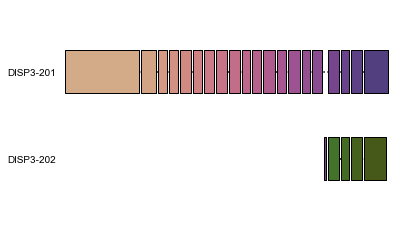

In [2]:
tfs['DISP3'].exon_diagram()

In [3]:
# map from alignment coordinates to exon coordinates...
tfs['DISP3'].pairwise_changes_relative_to_reference('DISP3-201', 'DISP3-202')

'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

In [4]:
for name, tf in tfs.items():
    if len(tf.orfs) < 2:
        continue
    if 'F' in tf.pairwise_changes_relative_to_reference(tf.orfs[0].name, tf.orfs[1].name):
        print(name)
        break

DISP3


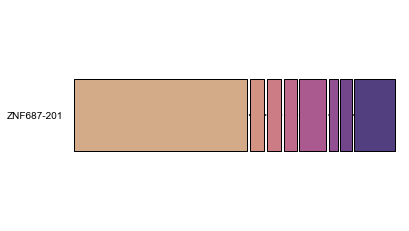

In [5]:
tfs['ZNF687'].exon_diagram()

In [6]:
df = pd.concat([g.aa_feature_disruption(g.orfs[0].name) for g in tfs.values()])
dbd = load_DNA_binding_domains()
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene'].size())
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')
df['is_affected'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0

In [7]:
dbd_acc = set(dbd['pfam'].values).union(set(df['accession'][df['accession'].str.startswith('C2H2_ZF_array')].unique()))

In [8]:
len(dbd_acc)

234

In [9]:
len({k for k, v in clans.items() if v in dbd['clan'].values})

912

In [19]:
# random shuffle
# this will take a long time
rnd = []
for g in tqdm.tqdm(tfs.values()):
    rnd.append(g.random_aa_seq_feature_shuffle(g.orfs[0].name, n=100, subset=dbd_acc))
rnd = pd.concat(rnd)

12%|█▏        | 337/2746 [01:14<08:49,  4.55it/s]


KeyboardInterrupt: 

In [141]:
rnd['is_DBD'] = rnd['accession'].isin(dbd['pfam'].values) | rnd['accession'].str.startswith('C2H2_ZF_array')
rnd['is_affected'] = (rnd['deletion'] + rnd['insertion'] + rnd['frameshift']) > 0

False    1077
True     1026
Name: is_affected, dtype: int64


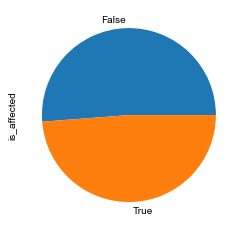

In [10]:
print(df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts())
df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts().plot.pie()

In [21]:
df['is_DBD'].sum()

3495

In [143]:
rnd['is_DBD'].sum()

349500

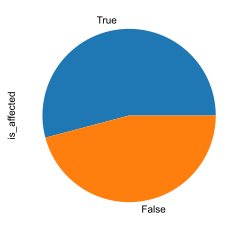

In [142]:
rnd.loc[rnd['is_DBD'], :].groupby(['alt_iso', 'random_sample'])['is_affected'].any().value_counts().plot.pie()

1102.89


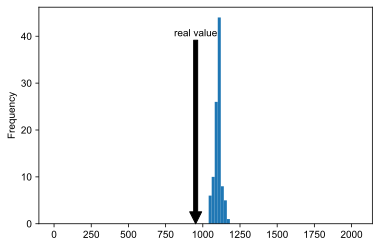

In [147]:
n = df.loc[df['is_DBD'], 'alt_iso'].nunique()
true_k = df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().sum()
(rnd.loc[rnd['is_DBD'], :]
    .groupby(['random_sample', 'alt_iso'])['is_affected']
    .any()
    .sum(level=0)
    .plot.hist(range=(0, n), bins=100))
print(rnd.loc[rnd['is_DBD'], :]
    .groupby(['random_sample', 'alt_iso'])['is_affected']
    .any()
    .sum(level=0).mean())
plt.annotate(xy=(true_k, 0),
                s='real value',
                xytext=(true_k, 40),  # TODO: change y position
                arrowprops={'color': 'black'},
                ha='center')
plt.savefig('../../figures/DBD_affected_100_randomizations.pdf',
            bbox_inches='tight')

In [22]:
%%time
df_null = pd.concat([g.null_fraction_per_aa_feature(g.orfs[0].name) for g in tfs.values()])
df['null_fraction_affected'] = df_null['null_fraction_affected']

CPU times: user 3min 23s, sys: 2.21 s, total: 3min 25s
Wall time: 3min 40s


In [23]:
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_DBD,is_affected,null_fraction_affected
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,0,0,0,22,True,False,0.032695
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,0,0,0,22,True,False,0.098884
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,0,0,0,22,True,False,0.117225
3,PRDM16,PRDM16-201,PRDM16-203,C2H2_ZF_array_6,0,0,0,164,True,False,0.039568
4,PRDM16,PRDM16-201,PRDM16-206,C2H2_ZF_array_6,0,0,0,164,True,False,0.223022


In [24]:
(len(tfs),
 sum(len(tf.orfs) > 1 for tf in tfs.values()),
 len([tf for tf in tfs.values() if any(len(orf.aa_seq_features) >= 1 for orf in tf.orfs)]),
 df['gene'].nunique(), 
 df.loc[df['is_DBD'], 'gene'].nunique())

(2746, 1739, 1601, 946, 788)

In [25]:
from poibin import PoiBin

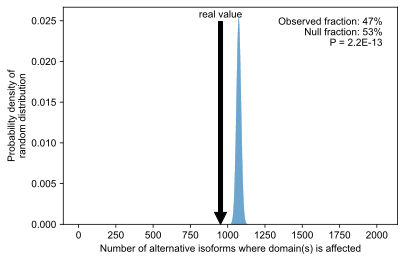

In [26]:
def domain_disruption_significance_plot(df, ax=None):
    if ax is None:
        ax = plt.gca()
    n = df['alt_iso'].nunique()
    true_k = df.groupby('alt_iso')['is_affected'].any().sum()

    def prob_or(probabilities):
        return 1 - (np.prod(1 - probabilities))

    null_p = df.groupby('alt_iso')['null_fraction_affected'].apply(prob_or).values
    pval = PoiBin(null_p).cdf(true_k)
    pmf = PoiBin(null_p).pmf(range(n))
    ax.bar(x=range(n),
            height=pmf,
            width=1.)
    ax.annotate(xy=(true_k, 0),
                s='real value',
                xytext=(true_k, max(pmf)),
                arrowprops={'color': 'black'},
                ha='center')
    ax.set_ylabel('Probability density of\nrandom distribution')
    ax.set_xlabel('Number of alternative isoforms where domain(s) is affected')
    ax.text(n,
            pmf.max(),
            'Observed fraction: {:.0%}\nNull fraction: {:.0%}\nP = {:.1E}'.format(true_k / n, pmf.argmax() / n, pval),
            ha='right',
            va='top')

domain_disruption_significance_plot(df.loc[df['is_DBD'], :])
plt.savefig('../../figures/all_DBD_affected_random_dist.pdf', bbox_inches='tight')

In [161]:
df.loc[df['is_DBD'], 'alt_iso'].nunique()

2038

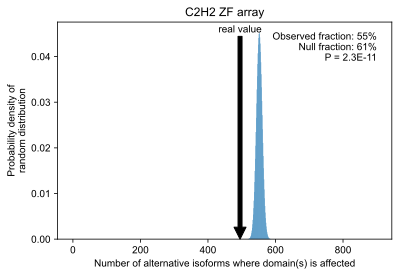

In [158]:
domain_disruption_significance_plot(df.loc[df['accession'].str.startswith('C2H2_ZF_array'), :])
plt.title('C2H2 ZF array')
plt.savefig('../../figures/C2H2_ZF_array_affected_random_dist.pdf', bbox_inches='tight')

In [164]:
n_dbd

18

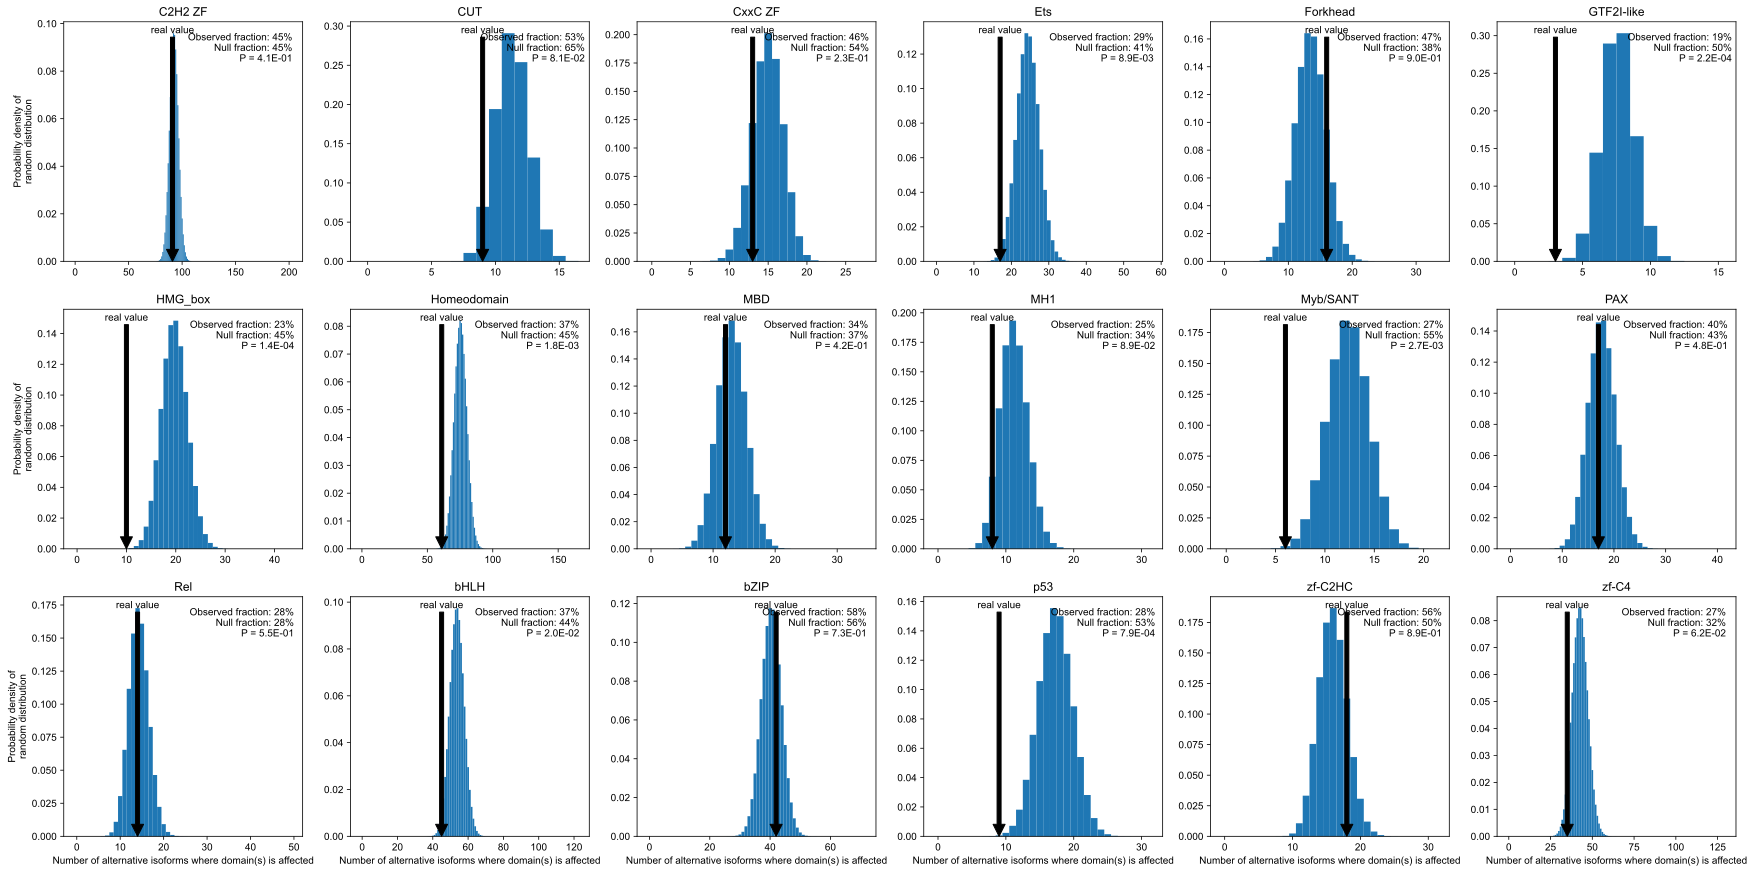

In [171]:
above_size_cutoff = (dbd['num_genes'] >= 30)
n_dbd = above_size_cutoff.sum()
fig, axes = plt.subplots(3, 6)
fig.set_size_inches(5 * 6, 5 * 3)
for (_i, row), ax in zip(dbd.loc[above_size_cutoff].iterrows(), axes.flatten()):
    ax.set_title(row['dbd'])
    domain_disruption_significance_plot(df.loc[df['accession'] == row['pfam'], :],
                                        ax=ax)
for ax in axes[:, 1:].flatten():
    ax.set_ylabel('')
for ax in axes[:-1, :].flatten():
    ax.set_xlabel('')
plt.savefig('../../figures/different_DBDs_affected_random_dist.pdf', bbox_inches='tight')

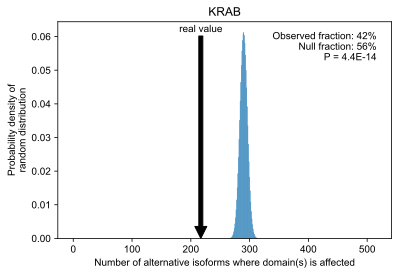

In [172]:
fig, ax = plt.subplots(1, 1)
ax.set_title('KRAB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF01352', :],
                                    ax=ax)
plt.savefig('../../figures/KRAB_affected_random_dist.pdf', bbox_inches='tight')

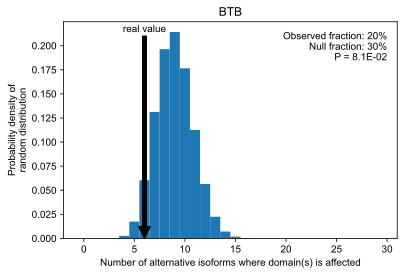

In [173]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BTB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF00651', :],
                                    ax=ax)
plt.savefig('../../figures/BTB_affected_random_dist.pdf', bbox_inches='tight')

217 516 4.3632881257193133e-14
270 475 6.47217536183832e-14
154 259 3.566634834695215e-14
94 185 0.6446206085791074
65 130 0.540114064178459
27 73 0.0001370766428581122
45 81 0.98524448811746
47 72 3.767690967623473e-06
38 59 0.0010096186282257137
6 30 0.08061308122817668


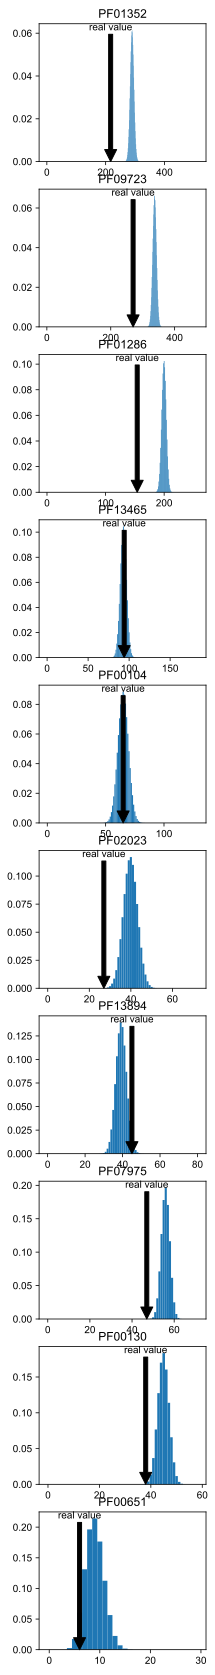

In [138]:
fig, axes = plt.subplots(10, 1)
fig.set_size_inches(3, 30)
for pfam_ac, ax in zip(df.loc[~df['is_DBD'], :].groupby('accession')['gene'].nunique().sort_values(ascending=False).head(10).index, axes):
    ax.set_title(pfam_ac)
    domain_disruption_significance_plot(df.loc[df['accession'] == pfam_ac, :],
                                    ax=ax)

In [116]:
dbd = dbd.drop([56])  # duplicate entry in table

In [141]:
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])
pfam.head()

,pfam_accession,clan,clan_name,short_name,name
0,PF00001,CL0192,GPCR_A,7tm_1,7 transmembrane receptor (rhodopsin family)
1,PF00002,CL0192,GPCR_A,7tm_2,7 transmembrane receptor (Secretin family)
2,PF00003,CL0192,GPCR_A,7tm_3,7 transmembrane sweet-taste receptor of 3 GCPR
3,PF00004,CL0023,P-loop_NTPase,AAA,ATPase family associated with various cellular...
4,PF00005,CL0023,P-loop_NTPase,ABC_tran,ABC transporter


In [154]:
df.loc[df['accession'].str.startswith('C2H2_ZF_array'), 'accession'] = 'C2H2_ZF_array'
doms = df.groupby('accession')['alt_iso'].nunique().to_frame(name='n_alt_iso')
doms['k'] = df.groupby(['accession', 'alt_iso'])['is_affected'].any().sum(level='accession')
doms['f'] = doms['k'] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


null_p = df.groupby(['accession', 'alt_iso'])['null_fraction_affected'].apply(prob_or)
doms['null_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
doms['null_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
doms['null_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']
doms.head()

,n_alt_iso,k,f,null_99CI_low,null_99CI_high,null_center,is_DBD,domain_name
accession,,,,,,,,
C2H2_ZF_array,900,495.0,0.550000,0.591111,0.636667,0.613333,True,C2H2 ZF array
PF01352,516,217.0,0.420543,0.532946,0.591085,0.562016,False,KRAB box
PF09723,475,270.0,0.568421,0.680000,0.738947,0.709474,False,Zinc ribbon domain
PF01286,259,154.0,0.594595,0.737452,0.806950,0.772201,False,XPA protein N-terminal
PF00096,203,91.0,0.448276,0.408867,0.502463,0.453202,True,C2H2 ZF


In [148]:
pfam.set_index('pfam_accession')['name']

pfam_accession
PF00001          7 transmembrane receptor (rhodopsin family)
PF00002           7 transmembrane receptor (Secretin family)
PF00003       7 transmembrane sweet-taste receptor of 3 GCPR
PF00004    ATPase family associated with various cellular...
PF00005                                      ABC transporter
                                 ...                        
PF18867                            HEPN-like integron domain
PF18868                     Zinc finger C2H2-type, 3 repeats
PF18869                                    RnaseLS-like HEPN
PF18870                         HEPN/RES N-terminal domain 1
PF18871                      HEPN/Toprim N-terminal domain 1
Name: name, Length: 17929, dtype: object

In [153]:
#doms['domain_name'] = doms.index.map(dbd.set_index('pfam')['dbd']).fillna('C2H2 ZF array')


,n_alt_iso,k,f,null_99CI_low,null_99CI_high,null_center,is_DBD,domain_name
accession,,,,,,,,
C2H2_ZF_array,900,495.0,0.550000,0.591111,0.636667,0.613333,True,C2H2 ZF array
PF01352,516,NaN,NaN,0.532946,0.591085,0.562016,False,KRAB box
PF09723,475,NaN,NaN,0.680000,0.738947,0.709474,False,Zinc ribbon domain
PF01286,259,NaN,NaN,0.737452,0.806950,0.772201,False,XPA protein N-terminal
PF00096,203,91.0,0.448276,0.408867,0.502463,0.453202,True,C2H2 ZF
...,...,...,...,...,...,...,...,...
PF14432,1,NaN,NaN,1.000000,1.000000,1.000000,False,DYW family of nucleic acid deaminases
PF06464,1,NaN,NaN,0.000000,1.000000,0.000000,False,DMAP1-binding Domain
PF14291,1,NaN,NaN,0.000000,1.000000,0.000000,False,Domain of unknown function (DUF4371)


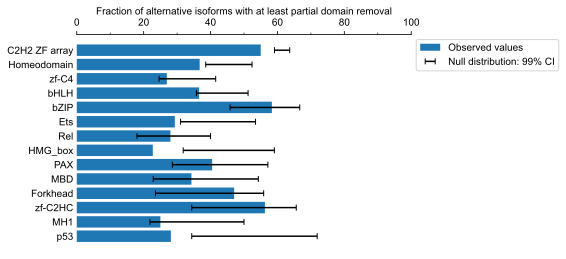

In [145]:
fig, ax = plt.subplots(1, 1)
cutoff = 30
data = doms.loc[doms['is_DBD'] &
                (doms['n_alt_iso'] >= cutoff) &
                 ~(doms.index.map(clans) == 'CL0361'), :].copy()
ax.barh(data.index, 
        data['f'].values * 100,
        label='Observed values')
ax.errorbar(y=data.index,
            x=data['null_center'].values * 100,
            xerr=[(data['null_center'] - data['null_99CI_low']).values * 100,
                  (data['null_99CI_high'] - data['null_center']).values * 100],
                          fmt='none',
                          capsize=3,
                          color='black',
                        label='Null distribution: 99% CI')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1, 1))
ax.set_yticklabels(data['domain_name'].values)
ax.set_xlim(0, 100)
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_tick_params(length=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel('Fraction of alternative isoforms with at least partial domain removal')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
plt.savefig('../../figures/DBD_partial_removal.pdf',
            bbox_inches='tight')

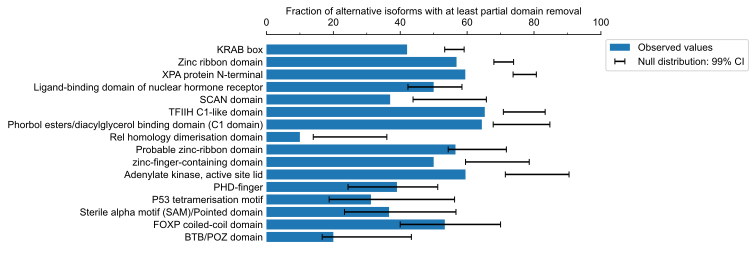

In [155]:
fig, ax = plt.subplots(1, 1)
cutoff = 30
data = doms.loc[~doms['is_DBD'] &
                (doms['n_alt_iso'] >= cutoff) &
                 ~(doms.index.map(clans) == 'CL0361'), :].copy()
ax.barh(data.index, 
        data['f'].values * 100,
        label='Observed values')
ax.errorbar(y=data.index,
            x=data['null_center'].values * 100,
            xerr=[(data['null_center'] - data['null_99CI_low']).values * 100,
                  (data['null_99CI_high'] - data['null_center']).values * 100],
                          fmt='none',
                          capsize=3,
                          color='black',
                        label='Null distribution: 99% CI')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1, 1))
ax.set_yticklabels(data['domain_name'].values)
ax.set_xlim(0, 100)
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_tick_params(length=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel('Fraction of alternative isoforms with at least partial domain removal')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
plt.savefig('../../figures/other_domain_partial_removal.pdf',
            bbox_inches='tight')

In [ ]:
# clans

In [159]:
# all domains, all DBD, non-DBD
doms = df.groupby('is_DBD')['alt_iso'].nunique().to_frame(name='n_alt_iso')
doms['k'] = df.groupby(['is_DBD', 'alt_iso'])['is_affected'].any().sum(level='is_DBD')
doms['f'] = doms['k'] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


null_p = df.groupby(['is_DBD', 'alt_iso'])['null_fraction_affected'].apply(prob_or)
doms['null_99CI_low'] = null_p.groupby('is_DBD').apply(null_quantile, 0.01)
doms['null_99CI_high'] = null_p.groupby('is_DBD').apply(null_quantile, 0.99)
doms['null_center'] = null_p.groupby('is_DBD').apply(null_quantile, 0.5)
doms.head()

,n_alt_iso,k,f,null_99CI_low,null_99CI_high,null_center
is_DBD,,,,,,
True,2038,952.0,0.467125,0.509323,0.545142,0.526987
False,1859,1041.0,0.559978,0.592792,0.628833,0.610543


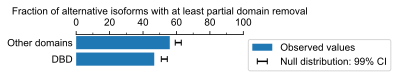

In [167]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 0.6)
data = doms.copy()
ax.barh(data.index, 
        data['f'].values * 100,
        label='Observed values')
ax.errorbar(y=data.index,
            x=data['null_center'].values * 100,
            xerr=[(data['null_center'] - data['null_99CI_low']).values * 100,
                  (data['null_99CI_high'] - data['null_center']).values * 100],
                          fmt='none',
                          capsize=3,
                          color='black',
                        label='Null distribution: 99% CI')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1, 1))
ax.set_xlim(0, 100)
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_tick_params(length=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel('Fraction of alternative isoforms with at least partial domain removal')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
ax.set_yticks([1, 0])
ax.set_yticklabels(['DBD', 'Other domains'])
plt.savefig('../../figures/DBD_vs_other_domain_partial_removal.pdf',
            bbox_inches='tight')

In [162]:
doms

,n_alt_iso,k,f,null_99CI_low,null_99CI_high,null_center
is_DBD,,,,,,
True,2038,952.0,0.467125,0.509323,0.545142,0.526987
False,1859,1041.0,0.559978,0.592792,0.628833,0.610543
